In [1]:
#Required Libraries
import pandas as pd
import numpy as np
from wordcloud import WordCloud
import matplotlib.pyplot as plt
from collections import Counter
import datetime
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
!pip install geopandas
!pip install descartes
import geopandas as gpd
from sklearn.preprocessing import OrdinalEncoder
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from keras.models import Sequential
from keras.layers import Dense
from sklearn.svm import SVC
from sklearn.metrics import classification_report, confusion_matrix
import random
from nltk import tokenize
from operator import itemgetter
import math
import nltk
nltk.download('punkt')
nltk.download('stopwords')

     |████████████████████████████████| 972kB 12.9MB/s 
     |████████████████████████████████| 14.8MB 186kB/s 
     |████████████████████████████████| 6.5MB 53.2MB/s 
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [2]:
#Functions required for pre-processing
def transform1(ls):
    ls1 = []
    for i in ls:
        if i[0]!="event_id":
            if i[0]=='nan' and i[1]=='nan':# Skip blank lines observed in excel sheet
                continue
            else:
                ls1.append(i)
    ls2 = transform2(ls1) # return combination of signal and disconnect rows as list
    return ls2

def transform2(ls1):
    i=0
    ls2 = []
    while i < len(ls1):
        if ls1[i][0]!='nan':
            nw = ls1[i]
            i+=2 # used to skip the title row (signal,disconnect)
            signal = []
            disconnect = []
            while ls1[i][0]=='nan': # used to append all signal and disconnect data as list
                signal.append(ls1[i][1])
                disconnect.append(ls1[i][2])
                i+=1
                if(i==len(ls1)): #required safety net
                    break
            nw.append(signal)
            nw.append(disconnect)
            ls2.append(nw) #Append dataframe to combine list
        else:
            i+=1    
    return ls2 #A list with data and corresponding signal time and disconnect cause as a List of List

In [3]:
combined = []
for i in range(1,4):
  df1 = pd.read_excel("/content/Crime Prediction.xlsx", header=0,sheet_name=str(i))
  df = df1.iloc[:,0:16]
  df = df.replace(np.nan,'nan', regex=True)
  ls = df.values.tolist()
  ls1 = transform1(ls)
  for item in ls1:
    combined.append(item)
print("Number of records after cleaning the data: ",len(combined))

Number of records after cleaning the data:  801


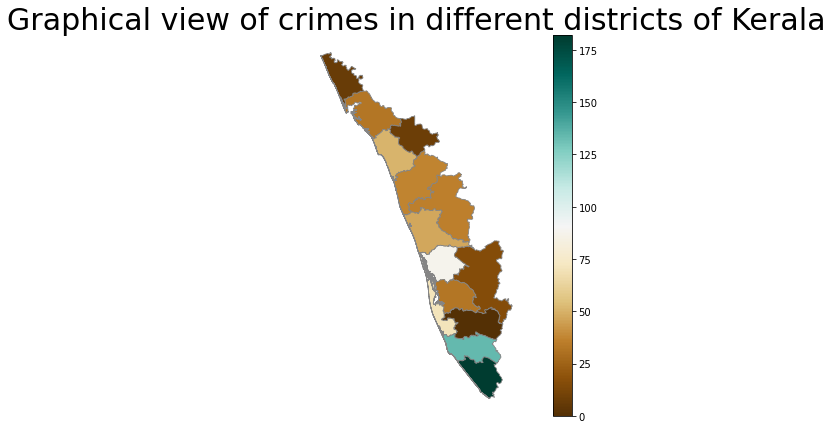

In [4]:
  count = {}
  for i in combined:
    if i[4] not in count:
      count[i[4]] = 1
    else:
      count[i[4]] +=1
  ls = []
  for i in count.keys():
    if(i=="nan"):
      continue
    temp = []
    temp.append(i)
    temp.append(count[i])
    ls.append(temp)
  district_wise=pd.DataFrame(ls)
  fp = "/content/drive/MyDrive/crime_data/IND_adm2.shp"
  map_df = gpd.read_file(fp)
  map_df = map_df[['NAME_1', 'NAME_2', 'geometry']]
  map_df = map_df[map_df['NAME_1']=='Kerala']
  merged = map_df.set_index('NAME_2').join(district_wise.set_index(0))
  merged[1].fillna(0, inplace=True)
  fig, ax = plt.subplots(1, figsize=(11, 7))
  ax.axis('off')
  ax.set_title('Graphical view of crimes in different districts of Kerala', fontdict={'fontsize': '30', 'fontweight' : '5'})
  # Plot the required Figure
  merged.plot(column=1, cmap='BrBG', linewidth=0.82, ax=ax, edgecolor='0.52',legend=True)

In [5]:
def parse_time(text):
  sep = '.'
  stripped = text.split(sep, 1)[0]
  return stripped

def convert_time(date_time1,date_time2):
  string1 = parse_time(date_time1)
  string2 = parse_time(date_time2)
  format = "%Y-%m-%d %H:%M:%S"
  datetime_str1 = datetime.datetime.strptime(string1, format)
  datetime_str2 = datetime.datetime.strptime(string2, format)
  time = str(datetime_str2 - datetime_str1)
  return sum(x * int(t) for x, t in zip([60, 1, 1/60], time.split(":")))

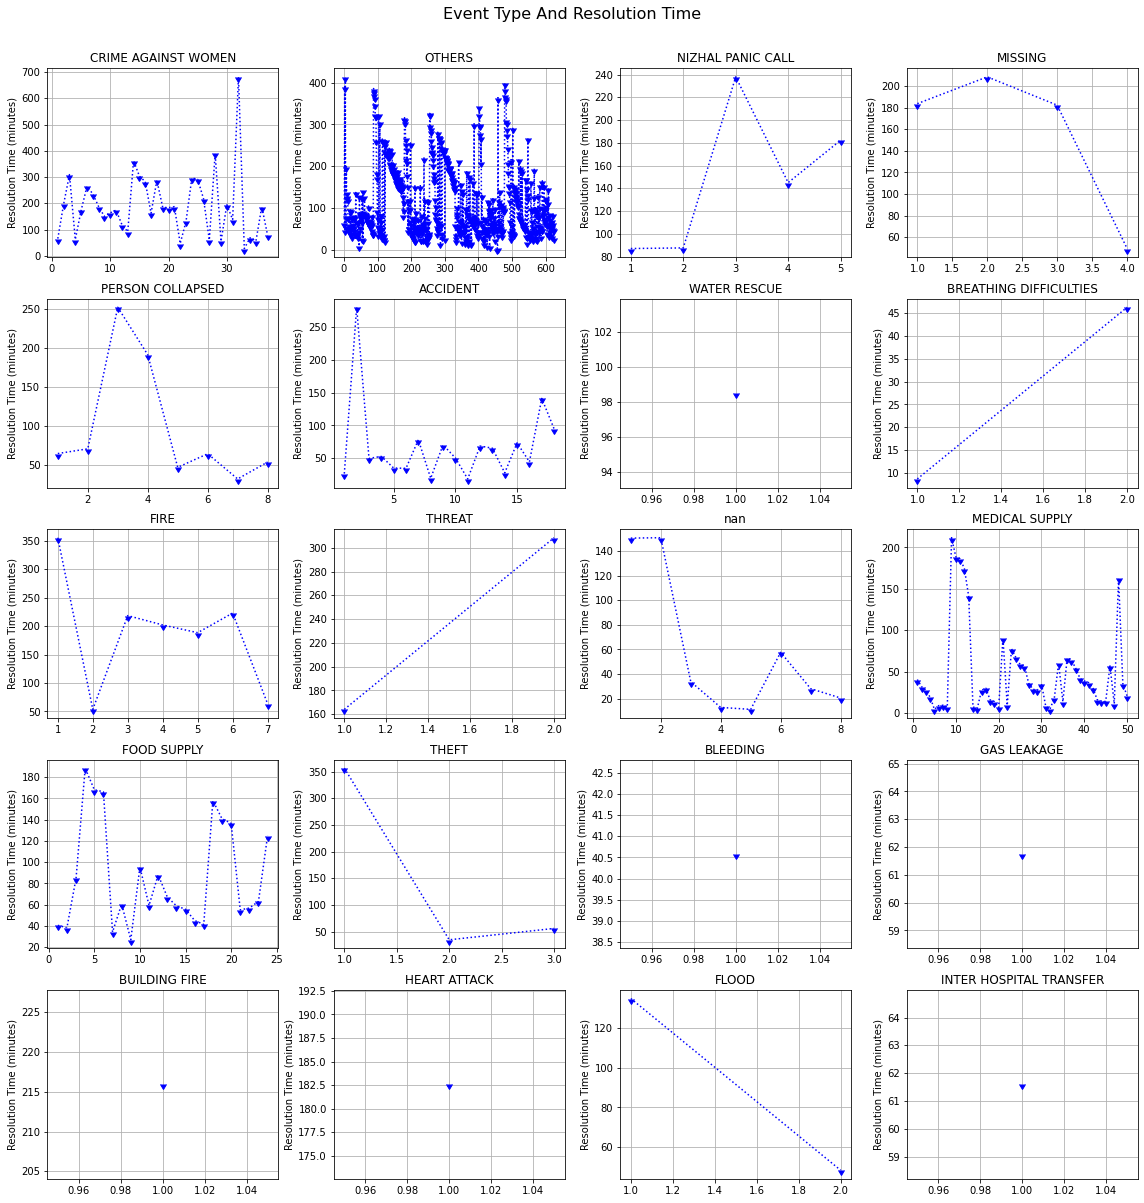

In [6]:
#Plot Event type and their Resolution time
dic = {}
for i,it in zip(combined,range(801)):
  if(i[2] in dic.keys()):
    dic[i[2]].append(convert_time(i[1],i[11]))
  else:
    try:
      dic[i[2]] = [convert_time(i[1],i[11])]
    except:
      print(it)
fig = plt.figure(figsize=(16, 17))
fig.suptitle('Event Type And Resolution Time',fontsize=16)
fig.subplots_adjust(hspace = .3, wspace=.001)
for key,it in zip(dic,range(1,21)):
  index = []
  for i in range(1,len(dic[key])+1):
    index.append(i)
  ax = fig.add_subplot(5,4,it)
  ax.plot(index,dic[key], color ='blue', marker = 11, lineStyle = ':')
  ax.set_title(key)
  ax.set_ylabel('Resolution Time (minutes)')
  ax.grid(True)
plt.tight_layout()
fig.subplots_adjust(top=0.93)
plt.show()

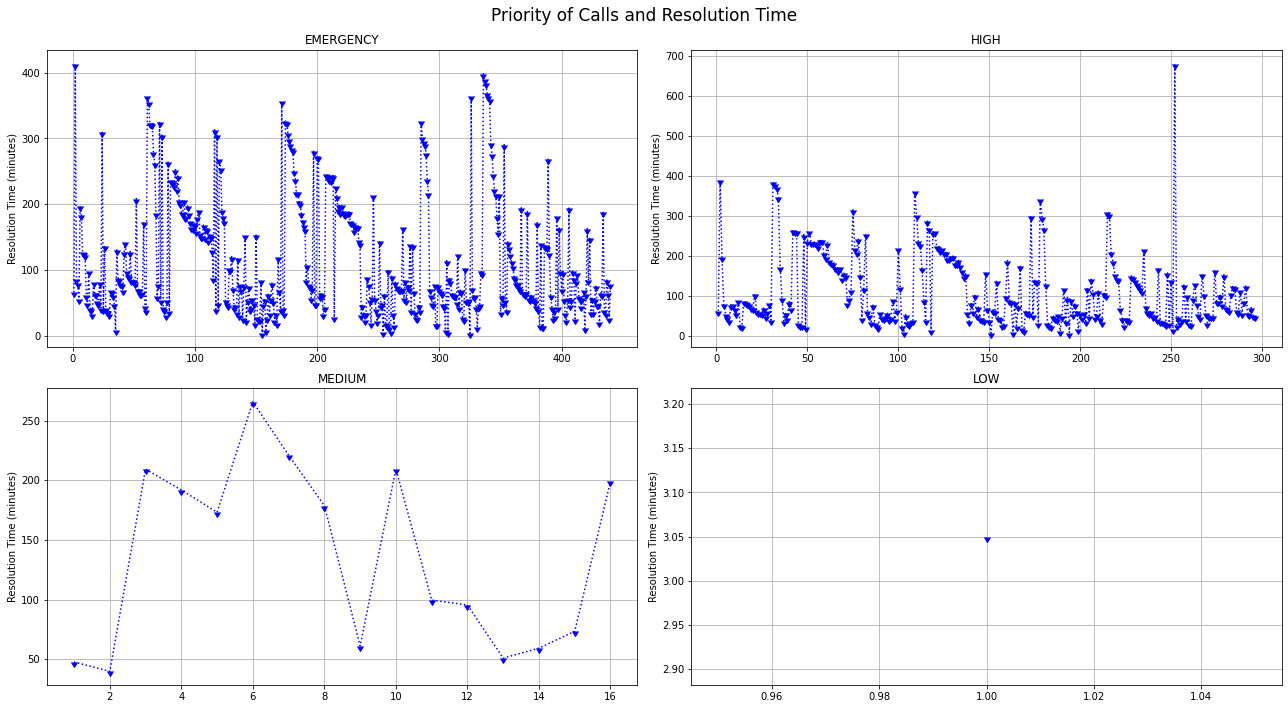

In [7]:
#Plot of Priority of calls and their Resolution time
dic = {}
for i in combined:
  if i[3]=='nan':
    continue
  if(i[3] in dic.keys()):
    dic[i[3]].append(convert_time(i[1],i[11]))
  else:
    dic[i[3]] = [convert_time(i[1],i[11])]
fig = plt.figure(figsize=(18, 10))
fig.suptitle('Priority of Calls and Resolution Time',fontsize=17)
fig.subplots_adjust(hspace = .3, wspace=.001)
for key,it in zip(dic,range(1,5)):
  index = []
  for i in range(1,len(dic[key])+1):
    index.append(i)
  ax = fig.add_subplot(2,2,it)
  ax.plot(index,dic[key], color='blue', lineStyle = ':', marker = 11)
  ax.set_title(key)
  ax.set_ylabel('Resolution Time (minutes)')
  ax.grid(True)
plt.tight_layout()
fig.subplots_adjust(top=0.92)
plt.show()

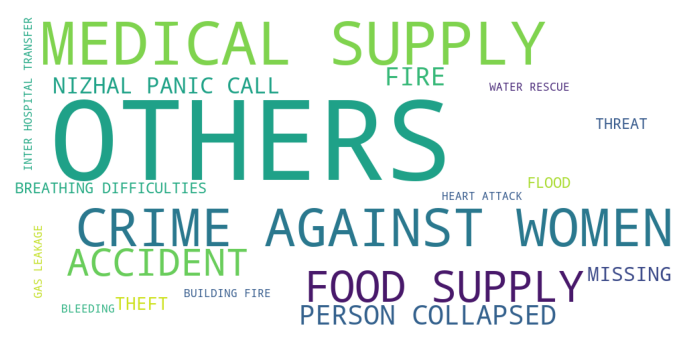

In [8]:
#WordCloud of the given dataset
ls = []
for i in combined:
  if i[2]=="nan":
    continue
  ls.append(i[2])
word_could_dict=Counter(ls)
wordcloud = WordCloud(width = 1000, height = 500, background_color ='white').generate_from_frequencies(word_could_dict)
plt.figure(figsize=(12,8))
plt.imshow(wordcloud)
plt.axis("off")
plt.show()

In [9]:
#Finding most occurred keywords in the data
string = ""
for i in combined:
  if(i[2]=="OTHERS"):
    string += str(i[15])
string = string.strip('\n')
stops = ["caller","informed","callers","PS",'ps','loc:','PS,','!','@','#','$','%','^','&','*','-','_',':',";",',','.','loc;','SAYS','IN','fish']
stop_words = set(stopwords.words('english'))
for i in stops:
  stop_words.add(i)
total_words = string.split()
total_word_length = len(total_words)
total_sentences = tokenize.sent_tokenize(string)
total_sent_len = len(total_sentences)
tf_score = {}
for each_word in total_words:
    each_word = each_word.replace('.','')
    if each_word not in stop_words:
        if each_word in tf_score:
            tf_score[each_word] += 1
        else:
            tf_score[each_word] = 1

#Each dictionary element is divided by total_word_length 
tf_score.update((x, y/int(total_word_length)) for x, y in tf_score.items())

def check_sent(word, sentences): 
    final = [all([w in x for w in word]) for x in sentences] 
    sent_len = [sentences[i] for i in range(0, len(final)) if final[i]]
    return int(len(sent_len))

idf_score = {}
for each_word in total_words:
    each_word = each_word.replace('.','')
    if each_word not in stop_words:
        if each_word in idf_score:
            idf_score[each_word] = check_sent(each_word, total_sentences)
        else:
            idf_score[each_word] = 1

idf_score.update((x, math.log(int(total_sent_len)/y)) for x, y in idf_score.items())

tf_idf_score = {key: tf_score[key] * idf_score.get(key, 0) for key in tf_score.keys()}

def get_top_n(dict_elem, n):
    result = dict(sorted(dict_elem.items(), key = itemgetter(1), reverse = True)[:n]) 
    return result

keywords = get_top_n(tf_idf_score,5)
print("Most occurred Keywords are:")
for key in keywords.keys():
  print(key)

Most occurred Keywords are:
gathered
near
people
gathering
shop


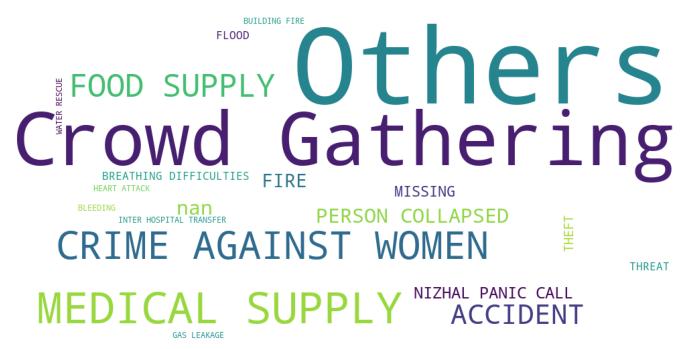

In [10]:
#Updated word cloud based on NLTK analysis
ls = []
for i in combined:
  if(i[2]=="OTHERS"):
    string = str(i[15])
    string = string.lower()
    if("gather" in string or "crowd" in string):
        ls.append("Crowd Gathering")
    else:
        ls.append("Others")
  else:
    ls.append(i[2])
word_could_dict=Counter(ls)
wordcloud = WordCloud(width = 1000, height = 500, background_color = 'white').generate_from_frequencies(word_could_dict)
plt.figure(figsize=(12,8))
plt.imshow(wordcloud)
plt.axis("off")
plt.show()

In [11]:
#Event type and their Disconnect causes(That is NORMAL_DISCONNECTION, MISSED_CALL, and REASON_UNKNOWN)
disconnect = {}
#Operations required to Populate Disconnect dictionary
for i in combined:
  if(i[2]=="nan"):
    continue
  elif(i[2]=="OTHERS"):
    string = str(i[15])
    string = string.lower()
    if("gather" in string or "crowd" in string):
        disconnect["CROWD GATHERING"] = [0,0,0]
    else:
        disconnect["OTHERS"] = [0,0,0]
  else:
    disconnect[i[2]] = [0,0,0]

#Method required to accumulate value in disconnect
def accumulate(ls,type):
  for j in ls:
    if(j=="NORMAL_DISCONNECTION"):
      disconnect[type][0] +=1
    elif(j=="MISSED_CALL"):
      disconnect[type][1] +=1
    else:
      disconnect[type][2] +=1

for i in combined:
  if(i[2]=="nan"):
    continue
  elif(i[2]=="OTHERS"):
    string = str(i[15])
    string = string.lower()
    if("gather" in string or "crowd" in string):
      accumulate(i[17],"CROWD GATHERING")
    else:
      accumulate(i[17],"OTHERS")
  else:
    accumulate(i[17],i[2])

In [12]:
#Visualization of Table
tab=[]
rowL=[]
colL = ["NORMAL DISCONNECTION","MISSED CALL","REASON UNKNOWN"]
colors = plt.cm.BuPu(np.linspace(0, 0.5, len(rowL)+1))
colors = colors[::-1]
for i in disconnect.keys():
  total = 0
  for k in disconnect[i]:
    total+= k
  lt = disconnect[i]
  lt = [f'{x/total*100:1.2f}' for x in lt]
  lt.insert(0,i)
  tab.append(lt)
  rowL.append(i)
from prettytable import PrettyTable
table = PrettyTable()
table.title = 'Event And their Call disconnections in percentages'
table.field_names = ["Events or Call types","NORMAL DISCONNECTION","MISSED CALL","REASON UNKNOWN"]
for i in tab:
  table.add_row(i)
print(table)

+-------------------------------------------------------------------------------+
|               Event And their Call disconnections in percentages              |
+-------------------------+----------------------+-------------+----------------+
|   Events or Call types  | NORMAL DISCONNECTION | MISSED CALL | REASON UNKNOWN |
+-------------------------+----------------------+-------------+----------------+
|   CRIME AGAINST WOMEN   |        52.82         |    20.00    |     27.18      |
|          OTHERS         |        62.98         |    16.03    |     20.99      |
|    NIZHAL PANIC CALL    |        75.00         |     0.00    |     25.00      |
|         MISSING         |        46.88         |    40.62    |     12.50      |
|     CROWD GATHERING     |        64.27         |    15.00    |     20.73      |
|     PERSON COLLAPSED    |        70.00         |    25.00    |      5.00      |
|         ACCIDENT        |        75.41         |    11.48    |     13.11      |
|       WATER RE

In [13]:
def check_slot(time):
  string1 = parse_time(time)
  format = "%Y-%m-%d %H:%M:%S"
  datetime_str1 = datetime.datetime.strptime(string1, format)
  tmp = str(datetime_str1)
  tmp = tmp.split(" ",1)[1]
  mins = sum(x * int(t) for x, t in zip([60, 1, 1/60], tmp.split(":")))
  if(mins<240):
    return "slot1"
  elif(240<=mins<480):
    return "slot2"
  elif(480<=mins<720):
    return "slot3"
  elif(720<=mins<960):
    return "slot4"
  elif(960<=mins<1200):
    return "slot5"
  else:
    return "slot6"

lis = []
for i in combined:
  tmp = []
  tmp.append(check_slot(i[1]))
  tmp.append(i[4])
  if(i[2]=="nan"):
    continue
  elif(i[2]=="OTHERS"):
    string = str(i[15])
    string = string.lower()
    if("gather" in string or "crowd" in string):
        tmp.append("Crowd Gathering")
    else:
        tmp.append("Others")
  else:
    tmp.append(i[2])
  lis.append(tmp)

In [14]:
#Classification using Logistic Regression
reg = pd.DataFrame(lis)
ord_enc = OrdinalEncoder()
reg["time"] = ord_enc.fit_transform(reg[[0]])
reg["district"] = ord_enc.fit_transform(reg[[1]])
reg["crime"] = ord_enc.fit_transform(reg[[2]])

x = reg.iloc[:, [3, 4]].values 
y = reg.iloc[:, 5].values

xtrain, xtest, ytrain, ytest = train_test_split( x, y, test_size = 0.27, random_state = 0)
 
classifier1 = LogisticRegression(random_state = 0,solver='liblinear',max_iter=10000000)
classifier1.fit(xtrain, ytrain)
y_pred = classifier1.predict(xtest)

print ("Accuracy using liblinear solver: ",accuracy_score(ytest, y_pred))

classifier2 = LogisticRegression(random_state = 0,solver='sag',max_iter=10000000)
classifier2.fit(xtrain, ytrain)
y_pred = classifier2.predict(xtest)

print ("Accuracy using sag solver: ",accuracy_score(ytest, y_pred))

Accuracy using liblinear solver:  0.4186046511627907
Accuracy using sag solver:  0.42790697674418604


In [15]:
#Classification using Supprt Vector Machine Algorithm
x = reg.iloc[:, [3, 4]].values 
y = reg.iloc[:, 5].values
xtrain, xtest, ytrain, ytest = train_test_split( x, y, test_size = 0.27, random_state = 0)
svclassifier = SVC(kernel='linear')
svclassifier.fit(xtrain, ytrain)
y_pred = svclassifier.predict(xtest)
print(classification_report(ytest,y_pred))

              precision    recall  f1-score   support

         0.0       0.00      0.00      0.00         4
         1.0       0.00      0.00      0.00         1
         4.0       0.00      0.00      0.00        11
         5.0       0.00      0.00      0.00        79
         6.0       0.00      0.00      0.00         2
         8.0       0.00      0.00      0.00         8
        12.0       0.57      0.33      0.42        12
        13.0       0.00      0.00      0.00         2
        14.0       0.00      0.00      0.00         1
        15.0       0.43      0.99      0.60        90
        16.0       0.00      0.00      0.00         3
        18.0       0.00      0.00      0.00         1
        19.0       0.00      0.00      0.00         1

    accuracy                           0.43       215
   macro avg       0.08      0.10      0.08       215
weighted avg       0.21      0.43      0.27       215



/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [16]:
#Classification using K-Nearest neighbor Algorithm
x = reg.iloc[:, [3, 4]].values 
y = reg.iloc[:, 5].values
xtrain, xtest, ytrain, ytest = train_test_split( x, y, test_size = 0.27, random_state = 0)
from sklearn.metrics import confusion_matrix
from sklearn.neighbors import KNeighborsClassifier
knn = KNeighborsClassifier(n_neighbors=5, metric='chebyshev')
knn.fit(xtrain, ytrain)
y_pred = knn.predict(xtest)
from sklearn.neighbors import KNeighborsClassifier
classifier = KNeighborsClassifier(n_neighbors = 4)
classifier.fit(xtrain, ytrain)
y_pred = classifier.predict(xtest)
from sklearn.metrics import classification_report, confusion_matrix
print(confusion_matrix(ytest, y_pred))
print(classification_report(ytest, y_pred))

[[ 0  0  0  2  0  0  0  0  0  2  0  0  0]
 [ 0  0  0  1  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  6  0  0  0  0  0  5  0  0  0]
 [ 0  0  1 61  0  0  0  0  0 17  0  0  0]
 [ 0  0  0  0  0  0  0  0  0  2  0  0  0]
 [ 0  0  1  2  0  0  0  0  0  5  0  0  0]
 [ 0  0  2  4  0  0  4  0  0  2  0  0  0]
 [ 0  0  1  0  0  0  0  0  0  1  0  0  0]
 [ 0  0  0  0  0  0  0  0  0  1  0  0  0]
 [ 0  0  2 48  0  0  0  0  0 40  0  0  0]
 [ 0  0  0  3  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0  1  0  0  0]
 [ 0  0  0  1  0  0  0  0  0  0  0  0  0]]
              precision    recall  f1-score   support

         0.0       0.00      0.00      0.00         4
         1.0       0.00      0.00      0.00         1
         4.0       0.00      0.00      0.00        11
         5.0       0.48      0.77      0.59        79
         6.0       0.00      0.00      0.00         2
         8.0       0.00      0.00      0.00         8
        12.0       1.00      0.33      0.50        12
        13.0       0

/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [17]:
#MLP Classification
from sklearn.neural_network import MLPClassifier
from sklearn.preprocessing import StandardScaler #Library for pre-processing
x = reg.iloc[:, [3, 4]].values 
y = reg.iloc[:, 5].values
xtrain, xtest, ytrain, ytest = train_test_split( x, y, test_size = 0.27, random_state = 0)
mlp = MLPClassifier(solver='sgd', alpha=1e-5,hidden_layer_sizes=(5, 2), random_state=1)
mlp.fit(xtrain, ytrain)
print(print(mlp.score(xtest, ytest)))

0.4325581395348837
None


/usr/local/lib/python3.6/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


In [18]:
#Classification using Deep Learning
x = reg.iloc[:, [3, 4]].values 
y = reg.iloc[:, 5].values
xtrain, xtest, ytrain, ytest = train_test_split( x, y, test_size = 0.27, random_state = 0)
model = Sequential()
model.add(Dense(10, input_dim=xtrain.shape[1], activation='tanh', kernel_initializer='he_normal'))
model.add(Dense(1, activation='sigmoid'))
model.compile(loss='binary_crossentropy', optimizer='sgd', metrics=['accuracy'])
model.fit(xtrain, ytrain, epochs=50, batch_size=16, verbose=2)
_, accuracy = model.evaluate(xtest, ytest, verbose=0)
print('Accuracy: %.2f using Deep Learning' % (accuracy*100))

Epoch 1/50
37/37 - 0s - loss: -1.2457e+02 - accuracy: 0.0035
Epoch 2/50
37/37 - 0s - loss: -4.3215e+02 - accuracy: 0.0000e+00
Epoch 3/50
37/37 - 0s - loss: -7.6054e+02 - accuracy: 0.0000e+00
Epoch 4/50
37/37 - 0s - loss: -1.0927e+03 - accuracy: 0.0000e+00
Epoch 5/50
37/37 - 0s - loss: -1.4248e+03 - accuracy: 0.0000e+00
Epoch 6/50
37/37 - 0s - loss: -1.7548e+03 - accuracy: 0.0000e+00
Epoch 7/50
37/37 - 0s - loss: -2.0848e+03 - accuracy: 0.0000e+00
Epoch 8/50
37/37 - 0s - loss: -2.4170e+03 - accuracy: 0.0000e+00
Epoch 9/50
37/37 - 0s - loss: -2.7492e+03 - accuracy: 0.0000e+00
Epoch 10/50
37/37 - 0s - loss: -3.0813e+03 - accuracy: 0.0000e+00
Epoch 11/50
37/37 - 0s - loss: -3.4135e+03 - accuracy: 0.0000e+00
Epoch 12/50
37/37 - 0s - loss: -3.7487e+03 - accuracy: 0.0000e+00
Epoch 13/50
37/37 - 0s - loss: -4.0805e+03 - accuracy: 0.0000e+00
Epoch 14/50
37/37 - 0s - loss: -4.4131e+03 - accuracy: 0.0000e+00
Epoch 15/50
37/37 - 0s - loss: -4.7452e+03 - accuracy: 0.0000e+00
Epoch 16/50
37/37 - 0s 